In [1]:
# this is just to know how much time will it take to run this entire ipython notebook 
from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random
import warnings
warnings.filterwarnings("ignore")

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Preprocessing</h2> 

<h3>3.1.1 Converting / Merging whole data to required format: u_i, m_j, r_ij</h3>

In [4]:
start = datetime.now()
if not os.path.isfile('data.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # We re reading from each of the four files and appendig each rating to a global file 'train.csv'
    data = open('data.csv', mode='w')
    
    row = list()
    files=['combined_data_1.txt','combined_data_2.txt', 
           'combined_data_3.txt', 'combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:] # you don't have to do this.
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken :', datetime.now() - start)

Reading ratings from combined_data_1.txt...
Done.

Reading ratings from combined_data_2.txt...
Done.

Reading ratings from combined_data_3.txt...
Done.

Reading ratings from combined_data_4.txt...
Done.

Time taken : 0:03:17.816474


In [5]:
print("creating the dataframe from data.csv file..")
df = pd.read_csv('data.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

# we are arranging the ratings according to time.
print('Sorting the dataframe by date..')
df.sort_values(by='date', inplace=True)
print('Done..')

creating the dataframe from data.csv file..
Done.

Sorting the dataframe by date..
Done..


In [6]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [7]:
df.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

<h3>3.1.2 Checking for NaN values </h3>

In [8]:
# just to make sure that all Nan containing rows are deleted..
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


<h3>3.1.3 Removing Duplicates </h3>

In [9]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


 <h3>3.1.4 Basic Statistics (#Ratings, #Users, and #Movies)</h3>

In [10]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total data 
--------------------------------------------------

Total no of ratings : 100480507
Total No of Users   : 480189
Total No of movies  : 17770


<h2>3.2 Spliting data into Train and Test(80:20) </h2>

In [11]:
if not os.path.isfile('train.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

<h3>3.2.1 Basic Statistics in Train data (#Ratings, #Users, and #Movies)</h3>

In [12]:
# movies = train_df.movie.value_counts()
# users = train_df.user.value_counts()
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

Training data 
--------------------------------------------------

Total no of ratings : 80384405
Total No of Users   : 405041
Total No of movies  : 17424


<h3>3.2.2 Basic Statistics in Test data (#Ratings, #Users, and #Movies)</h3>

In [0]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

Test data 
--------------------------------------------------

Total no of ratings : 20096102
Total No of Users   : 349312
Total No of movies  : 17757


 <h2> 3.3 Exploratory Data Analysis on Train data </h2>

In [13]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

<h3> 3.3.1 Distribution of ratings </h3>

In [18]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

<p style="font-size:13px"> <b>Add new column (week day) to the data set  for analysis.</b></p>

In [0]:
# It is used to skip the warning ''SettingWithCopyWarning''.. 
pd.options.mode.chained_assignment = None  # default='warn'

train_df['day_of_week'] = train_df.date.dt.weekday_name

train_df.tail()

,movie,user,rating,date,day_of_week
80384400,12074,2033618,4,2005-08-08,Monday
80384401,862,1797061,3,2005-08-08,Monday
80384402,10986,1498715,5,2005-08-08,Monday
80384403,14861,500016,4,2005-08-08,Monday
80384404,5926,1044015,5,2005-08-08,Monday


In [14]:
train_df['month'] = train_df.date.dt.month

train_df.tail()

,movie,user,rating,date,month
80384400,12074,2033618,4,2005-08-08,8
80384401,862,1797061,3,2005-08-08,8
80384402,10986,1498715,5,2005-08-08,8
80384403,14861,500016,4,2005-08-08,8
80384404,5926,1044015,5,2005-08-08,8


In [20]:
from pickle import dump
with open('dataframe.pkl','wb') as f:
    dump(train_df,f)

In [ ]:
with open('dataframe.pkl','rb') as f:
    train_df=load(f)
f.close()

<IPython.core.display.Javascript object>


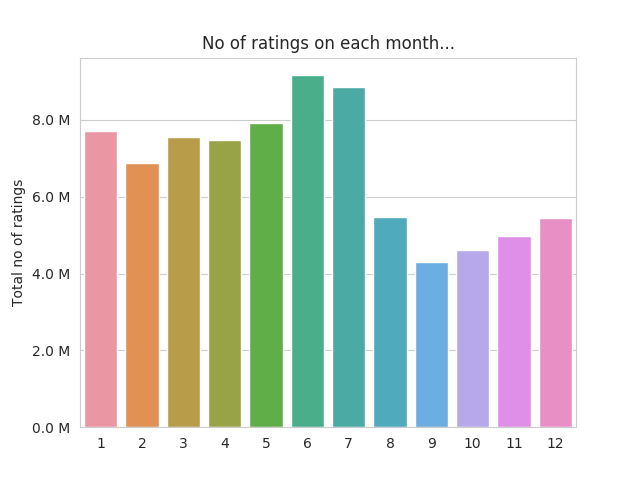

In [27]:
%matplotlib notebook
fig, ax = plt.subplots()
sns.countplot(x='month', data=train_df, ax=ax)
plt.title('No of ratings on each month...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

In [28]:
avg_month_df = train_df.groupby(by=['month'])['rating'].mean()
print(" AVerage ratings")
print("-"*30)
print(avg_month_df)
print("\n")

 AVerage ratings
------------------------------
month
1     3.551074
2     3.556291
3     3.579496
4     3.590111
5     3.592810
6     3.613396
7     3.624679
8     3.570252
9     3.550485
10    3.578523
11    3.567319
12    3.578930
Name: rating, dtype: float64




<h3>3.3.7 Finding Global average of all movie ratings, Average rating per user, and Average rating per movie</h3>

In [15]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

<h4> 3.3.7.2 finding average rating per user</h4>

In [10]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])


Average rating of user 10 : 3.3781094527363185


<h4> 3.3.7.3 finding average rating per movie</h4>

In [11]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15 :',train_averages['movie'][15])


 AVerage rating of movie 15 : 3.3038461538461537


<h4> 3.3.7.4 PDF's & CDF's of Avg.Ratings of Users & Movies (In Train Data)</h4>

<h3> 3.3.8 Cold Start problem </h3>

<h4> 3.3.8.1 Cold Start problem with Users</h4>

In [0]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 480189

Number of Users in Train data : 405041

No of Users that didn't appear in train data: 75148(15.65 %) 
 


> We might have to handle __new users__ ( ___75148___ ) who didn't appear in train data.

<h4> 3.3.8.2 Cold Start problem with Movies</h4>

In [0]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 17770

Number of Users in Train data : 17424

No of Movies that didn't appear in train data: 346(1.95 %) 
 


> We might have to handle __346 movies__ (small comparatively) in test data

 <h1> 4.  Machine Learning Models </h1>

<img src='images/models.jpg' width=500px>

In [8]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

<h2> 4.1 Sampling Data </h2>

<h3>4.1.1 Build sample train data from the train data</h3>

In [9]:
start = datetime.now()
path = "sample/small/sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    # get 25k users and 3k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=25000, no_movies=3000,
                                             path = path)

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.070867


<h3>4.1.2 Build sample test data from the test data</h3>

In [10]:
start = datetime.now()

path = "sample/small/sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    # get 5k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=5000, no_movies=500,
                                                 path = "sample/small/sample_test_sparse_matrix.npz")
print(datetime.now() - start)

Original Matrix : (users, movies) -- (349312 17757)
Original Matrix : Ratings -- 20096102

Sampled Matrix : (users, movies) -- (5000 500)
Sampled Matrix : Ratings -- 7333
Saving it into disk for furthur usage..
Done..

0:00:11.112220


<h2>4.2 Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)</h2>

In [11]:
sample_train_averages = dict()

<h3>4.2.1 Finding Global Average of all movie ratings</h3>

In [12]:
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.5875813607223455}

<h3>4.2.2 Finding Average rating per User</h3>

In [16]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 1515220 :',sample_train_averages['user'][1515220])


Average rating of user 1515220 : 3.923076923076923


<h3>4.2.3 Finding Average rating per Movie</h3>

In [17]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15153 :',sample_train_averages['movie'][15153])


 AVerage rating of movie 15153 : 2.752


<h2> 4.3 Featurizing data </h2>

In [18]:
print('\n No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('\n No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))


 No of ratings in Our Sampled train matrix is : 856986


 No of ratings in Our Sampled test  matrix is : 7333



<h3> 4.3.1 Featurizing data for regression problem </h3>

<h4> 4.3.1.1 Featurizing train data </h4>

In [19]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [20]:
############################################################
# It took me almost 10 hours to prepare this train dataset.#
############################################################
start = datetime.now()
if os.path.isfile('sample/small/reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('sample/small/reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the sim`ilar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

File already exists you don't have to prepare again...
0:00:00.000489


__Reading from the file to make a Train_dataframe__

In [21]:
reg_train = pd.read_csv('sample/small/reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,174683,10,3.587581,5.0,5.0,3.0,4.0,4.0,3.0,5.0,4.0,3.0,2.0,3.882353,3.611111,5
1,233949,10,3.587581,4.0,4.0,5.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0,2.692308,3.611111,3
2,555770,10,3.587581,4.0,5.0,4.0,4.0,5.0,4.0,2.0,5.0,4.0,4.0,3.795455,3.611111,4
3,767518,10,3.587581,2.0,5.0,4.0,4.0,3.0,5.0,5.0,4.0,4.0,3.0,3.884615,3.611111,5
4,894393,10,3.587581,3.0,5.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.000000,3.611111,4


<h4> 4.3.1.2 Featurizing test data </h4>

In [22]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [23]:
sample_train_averages['global']

3.5875813607223455

In [28]:
start = datetime.now()

if os.path.isfile('sample/small/reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('sample/small/reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

It is already created...


__Reading from the file to make a test dataframe __

In [29]:
reg_test_df = pd.read_csv('sample/small/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,5
1,941866,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,4
2,1737912,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3
3,1849204,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,4


<h3> 4.3.2 Transforming data for Surprise models</h3>

In [30]:
from surprise import Reader, Dataset
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

In [31]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

<h4> 4.3.2.2 Transforming test data </h4>

- Testset is just a list of (user, movie, rating) tuples. (Order in the tuple is impotant) 

In [32]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

<h2> 4.4 Applying Machine Learning models </h2>

In [33]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

 > __Utility functions for running regression models__

In [34]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

###################################################################
###################################################################
def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results
    

In [35]:
def hyperparametertune_xgboost(x_train, y_train):   
    x_cfl=xgb.XGBRegressor()
    params={
         'n_estimators':[100,200,500],
         'max_depth':[3,5,10]
    }
    random_cfl=GridSearchCV(x_cfl,param_grid=params,verbose=10,n_jobs=-1,)
    random_cfl.fit(x_train ,y_train)
    best_n_estimators = random_cfl.best_params_['n_estimators']
    best_max_depth = random_cfl.best_params_['max_depth']
    return best_n_estimators,best_max_depth


> __Utility functions for Surprise modes__

In [36]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

<h3> 4.4.1 XGBoost with initial 13 features </h3>

In [37]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [38]:
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
# hyperparamtertune xgboost
best_n_estimators,best_max_depth = hyperparametertune_xgboost(x_train, y_train)

first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=best_n_estimators,max_depth=best_max_depth)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=200 ...................................
[CV] max_depth=3, n_estimators=200 ...................................
[CV] max_depth=3, n_estimators=200 ...................................
[CV] max_depth=3, n_estimators=500 ...................................
[CV] max_depth=3, n_estimators=500 ...................................
[CV] max_depth=3, n_estimators=500 ...................................
[CV] max_depth=5, n_estimators=100 ...................................
[CV] max_depth=5, n_estimators=100 ...................................
[CV] max_depth=5, n_estimators=100 ...................................
[CV] max_depth=5, n_estimators=200 ...................................
[CV] max_depth=5,

[Parallel(n_jobs=-1)]: Done   2 out of  27 | elapsed:  1.2min remaining: 14.7min


[CV]  max_depth=3, n_estimators=100, score=0.35310704729978093, total= 1.2min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=5, n_estimators=100, score=0.3470150682726513, total= 1.8min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=5, n_estimators=100, score=0.3553713161736304, total= 1.8min
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=-1)]: Done   5 out of  27 | elapsed:  1.9min remaining:  8.3min


[CV]  max_depth=5, n_estimators=100, score=0.3935062098529509, total= 1.8min
[CV] max_depth=10, n_estimators=200 ..................................
[CV]  max_depth=3, n_estimators=200, score=0.3547221598977828, total= 2.0min
[CV] max_depth=10, n_estimators=200 ..................................
[CV]  max_depth=3, n_estimators=200, score=0.3464722217071253, total= 2.0min
[CV] max_depth=10, n_estimators=200 ..................................


[Parallel(n_jobs=-1)]: Done   8 out of  27 | elapsed:  2.1min remaining:  5.1min


[CV]  max_depth=3, n_estimators=200, score=0.3926256623560352, total= 2.1min
[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=5, n_estimators=200, score=0.347436606696376, total= 3.1min
[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=5, n_estimators=200, score=0.3940198640632676, total= 3.2min
[CV] max_depth=10, n_estimators=500 ..................................


[Parallel(n_jobs=-1)]: Done  11 out of  27 | elapsed:  3.4min remaining:  4.9min


[CV]  max_depth=5, n_estimators=200, score=0.35655393312939554, total= 3.2min
[CV]  max_depth=3, n_estimators=500, score=0.35630069227152183, total= 4.5min
[CV]  max_depth=3, n_estimators=500, score=0.3929248244824451, total= 4.7min


[Parallel(n_jobs=-1)]: Done  14 out of  27 | elapsed:  4.9min remaining:  4.6min


[CV]  max_depth=3, n_estimators=500, score=0.347014193865524, total= 4.9min
[CV]  max_depth=10, n_estimators=100, score=0.39159812383946185, total= 3.9min
[CV]  max_depth=10, n_estimators=100, score=0.3543453709783404, total= 4.6min


[Parallel(n_jobs=-1)]: Done  17 out of  27 | elapsed:  6.0min remaining:  3.5min


[CV]  max_depth=10, n_estimators=100, score=0.3461718051325742, total= 3.9min
[CV]  max_depth=5, n_estimators=500, score=0.35629513287722914, total= 7.2min
[CV]  max_depth=5, n_estimators=500, score=0.3927454581806223, total= 6.4min


[Parallel(n_jobs=-1)]: Done  20 out of  27 | elapsed:  7.8min remaining:  2.7min


[CV]  max_depth=10, n_estimators=200, score=0.3510619632993959, total= 6.0min
[CV]  max_depth=10, n_estimators=200, score=0.38706603831514486, total= 5.8min
[CV]  max_depth=10, n_estimators=200, score=0.34435221573857255, total= 6.2min


[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed:  8.6min remaining:  1.5min


[CV]  max_depth=5, n_estimators=500, score=0.34728945197190264, total= 7.2min
[CV]  max_depth=10, n_estimators=500, score=0.34412293678287753, total=11.4min
[CV]  max_depth=10, n_estimators=500, score=0.3785958767403117, total=10.4min
[CV]  max_depth=10, n_estimators=500, score=0.3364836577140401, total=10.5min


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 14.6min finished


Training the model..
[05:41:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_dep

[05:41:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:16] /work

[05:41:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[05:41:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[05:41:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[05:41:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[05:41:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[05:41:24] /work

<h3> 4.4.2 Suprise BaselineModel </h3>
    


In [39]:
from surprise import BaselineOnly 

In [40]:

# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:07.359446 

Evaluating the model with train data..
time taken : 0:00:07.399008
---------------
Train Data
---------------
RMSE : 0.9220478981418425

MAPE : 28.6415868708249

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.072660
---------------
Test Data
---------------
RMSE : 1.0655294354066949

MAPE : 34.406634720551914

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:14.832662


<h3> 4.4.3 XGBoost with initial 13 features + Surprise Baseline predictor </h3>

__Updating Train Data__

In [41]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,174683,10,3.587581,5.0,5.0,3.0,4.0,4.0,3.0,5.0,4.0,3.0,2.0,3.882353,3.611111,5,3.681393
1,233949,10,3.587581,4.0,4.0,5.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0,2.692308,3.611111,3,3.720150


__Updating Test Data__

In [42]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']
reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,808635,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,5,3.587581
1,941866,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,4,3.587581


In [43]:
# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
best_n_estimators,best_max_depth = hyperparametertune_xgboost(x_train, y_train)

xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=best_n_estimators ,max_depth =best_max_depth)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=200 ...................................
[CV] max_depth=3, n_estimators=200 ...................................
[CV] max_depth=3, n_estimators=200 ...................................
[CV] max_depth=3, n_estimators=500 ...................................
[CV] max_depth=3, n_estimators=500 ...................................
[CV] max_depth=3, n_estimators=500 ...................................
[CV] max_depth=5, n_estimators=100 ...................................
[CV] max_depth=5, n_estimators=100 ...................................
[CV] max_depth=5, n_estimators=100 ...................................
[CV] max_depth=5, n_estimators=200 ...................................
[CV] max_depth=5,

[Parallel(n_jobs=-1)]: Done   2 out of  27 | elapsed:  1.3min remaining: 16.0min


[CV]  max_depth=3, n_estimators=100, score=0.3908346479020725, total= 1.2min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=5, n_estimators=100, score=0.3935449043825494, total= 1.9min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=5, n_estimators=100, score=0.35546454657006155, total= 2.1min
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=-1)]: Done   5 out of  27 | elapsed:  2.2min remaining:  9.5min


[CV]  max_depth=5, n_estimators=100, score=0.34702966130950164, total= 2.1min
[CV] max_depth=10, n_estimators=200 ..................................
[CV]  max_depth=3, n_estimators=200, score=0.34633641362900247, total= 2.2min
[CV] max_depth=10, n_estimators=200 ..................................
[CV]  max_depth=3, n_estimators=200, score=0.3924669156519064, total= 2.3min
[CV] max_depth=10, n_estimators=200 ..................................


[Parallel(n_jobs=-1)]: Done   8 out of  27 | elapsed:  2.5min remaining:  5.8min


[CV]  max_depth=3, n_estimators=200, score=0.35467963114796963, total= 2.4min
[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=5, n_estimators=200, score=0.35626003287576746, total= 3.8min
[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=5, n_estimators=200, score=0.3939122180173181, total= 3.9min
[CV] max_depth=10, n_estimators=500 ..................................


[Parallel(n_jobs=-1)]: Done  11 out of  27 | elapsed:  4.1min remaining:  6.0min


[CV]  max_depth=5, n_estimators=200, score=0.34753645128109123, total= 4.0min
[CV]  max_depth=3, n_estimators=500, score=0.3468771849218997, total= 5.3min
[CV]  max_depth=3, n_estimators=500, score=0.392564067092644, total= 5.4min


[Parallel(n_jobs=-1)]: Done  14 out of  27 | elapsed:  5.7min remaining:  5.3min


[CV]  max_depth=10, n_estimators=100, score=0.35421820369207835, total= 4.5min
[CV]  max_depth=3, n_estimators=500, score=0.35561271068153666, total= 5.8min
[CV]  max_depth=10, n_estimators=100, score=0.3913488849728006, total= 4.5min


[Parallel(n_jobs=-1)]: Done  17 out of  27 | elapsed:  6.7min remaining:  3.9min


[CV]  max_depth=10, n_estimators=100, score=0.3460530584362781, total= 4.7min
[CV]  max_depth=5, n_estimators=500, score=0.35609523939266097, total= 8.3min
[CV]  max_depth=5, n_estimators=500, score=0.39339742602963257, total= 7.8min


[Parallel(n_jobs=-1)]: Done  20 out of  27 | elapsed:  9.2min remaining:  3.2min


[CV]  max_depth=5, n_estimators=500, score=0.3470530277004248, total= 7.9min
[CV]  max_depth=10, n_estimators=200, score=0.3518753755486591, total= 7.1min
[CV]  max_depth=10, n_estimators=200, score=0.34476354422585664, total= 7.1min


[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed:  9.7min remaining:  1.7min


[CV]  max_depth=10, n_estimators=200, score=0.38755282365398463, total= 7.3min
[CV]  max_depth=10, n_estimators=500, score=0.3449266429426826, total=12.8min
[CV]  max_depth=10, n_estimators=500, score=0.33986732939156916, total=11.9min
[CV]  max_depth=10, n_estimators=500, score=0.3809970961275815, total=12.3min


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 17.0min finished


Training the model..
[06:01:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:01:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:01:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:01:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:01:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:01:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:01:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:01:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_dep

[06:01:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:01:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:01:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:01:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:01:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:01:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:01:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:01:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:01:57] /work

[06:02:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[06:02:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:02:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:02:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:02:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[06:02:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[06:02:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[06:02:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[06:02:10] /work

<h3> 4.4.4 Surprise KNNBaseline predictor </h3>

In [44]:
from surprise import KNNBaseline

  <h4> 4.4.4.1 Surprise KNNBaseline with user user similarities</h4>

In [45]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:06:30.016576 

Evaluating the model with train data..
time taken : 0:21:45.397281
---------------
Train Data
---------------
RMSE : 0.4536279292470732

MAPE : 12.840252350475915

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.122927
---------------
Test Data
---------------
RMSE : 1.0651583775048283

MAPE : 34.3955649993566

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:28:15.537994


<h4> 4.4.4.2 Surprise KNNBaseline with movie movie similarities</h4>

In [46]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of movies instead of users

sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:12.816743 

Evaluating the model with train data..
time taken : 0:01:41.679245
---------------
Train Data
---------------
RMSE : 0.5038994796517224

MAPE : 14.168515366483724

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.084095
---------------
Test Data
---------------
RMSE : 1.066111028261093

MAPE : 34.41196670639251

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:01:54.580922


<h3> 4.4.5 XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor </h3>

__Preparing Train data __

In [47]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,174683,10,3.587581,5.0,5.0,3.0,4.0,4.0,3.0,5.0,4.0,3.0,2.0,3.882353,3.611111,5,3.681393,4.984495,4.884782
1,233949,10,3.587581,4.0,4.0,5.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0,2.692308,3.611111,3,3.720150,3.181296,3.295934


__Preparing Test data  __

In [48]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,808635,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,5,3.587581,3.587581,3.587581
1,941866,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,4,3.587581,3.587581,3.587581


In [49]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# declare the model
best_n_estimators,best_max_depth = hyperparametertune_xgboost(x_train, y_train)

xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15,n_estimators = best_n_estimators,max_depth = best_max_depth)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=200 ...................................
[CV] max_depth=3, n_estimators=200 ...................................
[CV] max_depth=3, n_estimators=200 ...................................
[CV] max_depth=3, n_estimators=500 ...................................
[CV] max_depth=3, n_estimators=500 ...................................
[CV] max_depth=3, n_estimators=500 ...................................
[CV] max_depth=5, n_estimators=100 ...................................
[CV] max_depth=5, n_estimators=100 ...................................
[CV] max_depth=5, n_estimators=100 ...................................
[CV] max_depth=5, n_estimators=200 ...................................
[CV] max_depth=5,

[Parallel(n_jobs=-1)]: Done   2 out of  27 | elapsed:  1.7min remaining: 21.2min


[CV]  max_depth=3, n_estimators=100, score=0.35308002539068883, total= 1.7min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=5, n_estimators=100, score=0.3470991535501775, total= 2.8min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=3, n_estimators=200, score=0.35457952610390175, total= 2.9min
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=-1)]: Done   5 out of  27 | elapsed:  3.0min remaining: 13.1min


[CV]  max_depth=5, n_estimators=100, score=0.35541291360437144, total= 2.9min
[CV] max_depth=10, n_estimators=200 ..................................
[CV]  max_depth=3, n_estimators=200, score=0.3925215593384972, total= 3.0min
[CV] max_depth=10, n_estimators=200 ..................................
[CV]  max_depth=5, n_estimators=100, score=0.39355271617032744, total= 3.1min
[CV] max_depth=10, n_estimators=200 ..................................


[Parallel(n_jobs=-1)]: Done   8 out of  27 | elapsed:  3.2min remaining:  7.6min


[CV]  max_depth=3, n_estimators=200, score=0.34623341196714874, total= 3.2min
[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=5, n_estimators=200, score=0.34738668965655584, total= 5.1min
[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=5, n_estimators=200, score=0.3936366976055068, total= 5.5min
[CV] max_depth=10, n_estimators=500 ..................................


[Parallel(n_jobs=-1)]: Done  11 out of  27 | elapsed:  5.7min remaining:  8.3min


[CV]  max_depth=5, n_estimators=200, score=0.35596667155661343, total= 5.6min
[CV]  max_depth=3, n_estimators=500, score=0.35578347246633, total= 6.9min
[CV]  max_depth=3, n_estimators=500, score=0.3927887616190398, total= 7.0min


[Parallel(n_jobs=-1)]: Done  14 out of  27 | elapsed:  7.3min remaining:  6.7min


[CV]  max_depth=3, n_estimators=500, score=0.34666092191414644, total= 7.2min
[CV]  max_depth=10, n_estimators=100, score=0.35378882973586034, total= 6.6min
[CV]  max_depth=10, n_estimators=100, score=0.3452480461429277, total= 5.8min


[Parallel(n_jobs=-1)]: Done  17 out of  27 | elapsed:  8.9min remaining:  5.2min


[CV]  max_depth=10, n_estimators=100, score=0.39072485432277193, total= 6.0min
[CV]  max_depth=5, n_estimators=500, score=0.35577448535440614, total=11.1min
[CV]  max_depth=5, n_estimators=500, score=0.3931221259744019, total=10.3min


[Parallel(n_jobs=-1)]: Done  20 out of  27 | elapsed: 12.1min remaining:  4.2min


[CV]  max_depth=5, n_estimators=500, score=0.34678193515310296, total=10.4min
[CV]  max_depth=10, n_estimators=200, score=0.3874262119586236, total= 9.2min
[CV]  max_depth=10, n_estimators=200, score=0.350792024843279, total= 9.5min


[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed: 12.8min remaining:  2.2min


[CV]  max_depth=10, n_estimators=200, score=0.34308269624828736, total= 9.7min
[CV]  max_depth=10, n_estimators=500, score=0.3454143047737188, total=17.6min
[CV]  max_depth=10, n_estimators=500, score=0.3816864466368638, total=16.0min
[CV]  max_depth=10, n_estimators=500, score=0.33798065588767745, total=16.0min


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 22.4min finished


Training the model..
Done. Time taken : 0:00:45.643673

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0810948687615936
MAPE :  33.357433066800965


<h3> 4.4.6 Matrix Factorization Techniques </h3>

<h4> 4.4.6.1 SVD Matrix Factorization User Movie intractions </h4>

In [50]:
from surprise import SVD

In [51]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:48.438233 

Evaluating the model with train data..
time taken : 0:00:09.337355
---------------
Train Data
---------------
RMSE : 0.6746731413267192

MAPE : 20.05479554670084

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.069641
---------------
Test Data
---------------
RMSE : 1.06539583258785

MAPE : 34.26066030096141

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:57.846808


  <h4> 4.4.6.2 SVD Matrix Factorization with implicit feedback from user ( user rated movies ) </h4>

In [52]:
from surprise import SVDpp

In [53]:
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results


Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:33:51.240977 

Evaluating the model with train data..
time taken : 0:01:40.260522
---------------
Train Data
---------------
RMSE : 0.6641918784333875

MAPE : 19.24213231265533

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.085321
---------------
Test Data
---------------
RMSE : 1.0664479484659375

MAPE : 34.15617562453539

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:35:31.587902


<h3> 4.4.7 XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

__Preparing Train data__

In [54]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,174683,10,3.587581,5.0,5.0,3.0,4.0,4.0,3.0,5.0,...,3.0,2.0,3.882353,3.611111,5,3.681393,4.984495,4.884782,4.073348,3.884115
1,233949,10,3.587581,4.0,4.0,5.0,1.0,3.0,2.0,3.0,...,3.0,3.0,2.692308,3.611111,3,3.720150,3.181296,3.295934,3.649073,3.618476


__Preparing Test data  __

In [55]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,...,3.587581,3.587581,3.587581,3.587581,5,3.587581,3.587581,3.587581,3.587581,3.587581
1,941866,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,...,3.587581,3.587581,3.587581,3.587581,4,3.587581,3.587581,3.587581,3.587581,3.587581


In [56]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']


best_n_estimators,best_max_depth = hyperparametertune_xgboost(x_train, y_train)

xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15 ,n_estimators = best_n_estimators,max_depth = best_max_depth)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=200 ...................................
[CV] max_depth=3, n_estimators=200 ...................................
[CV] max_depth=3, n_estimators=200 ...................................
[CV] max_depth=3, n_estimators=500 ...................................
[CV] max_depth=3, n_estimators=500 ...................................
[CV] max_depth=3, n_estimators=500 ...................................
[CV] max_depth=5, n_estimators=100 ...................................
[CV] max_depth=5, n_estimators=100 ...................................
[CV] max_depth=5, n_estimators=100 ...................................
[CV] max_depth=5, n_estimators=200 ...................................
[CV] max_depth=5,

[Parallel(n_jobs=-1)]: Done   2 out of  27 | elapsed:  1.9min remaining: 23.4min


[CV]  max_depth=3, n_estimators=100, score=0.39082448811309634, total= 1.9min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=5, n_estimators=100, score=0.39327697015888563, total= 3.1min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=5, n_estimators=100, score=0.3471601393295224, total= 3.2min
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=-1)]: Done   5 out of  27 | elapsed:  3.4min remaining: 14.8min


[CV]  max_depth=5, n_estimators=100, score=0.35534956466975, total= 3.4min
[CV] max_depth=10, n_estimators=200 ..................................
[CV]  max_depth=3, n_estimators=200, score=0.35462656989981756, total= 3.8min
[CV] max_depth=10, n_estimators=200 ..................................
[CV]  max_depth=3, n_estimators=200, score=0.3463870422952493, total= 3.8min
[CV] max_depth=10, n_estimators=200 ..................................


[Parallel(n_jobs=-1)]: Done   8 out of  27 | elapsed:  3.9min remaining:  9.2min


[CV]  max_depth=3, n_estimators=200, score=0.39243252037214255, total= 4.3min
[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=5, n_estimators=200, score=0.3936587788568017, total= 6.3min
[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=5, n_estimators=200, score=0.3471714966014293, total= 7.0min
[CV] max_depth=10, n_estimators=500 ..................................


[Parallel(n_jobs=-1)]: Done  11 out of  27 | elapsed:  7.2min remaining: 10.5min


[CV]  max_depth=5, n_estimators=200, score=0.35571709901138826, total= 7.1min
[CV]  max_depth=3, n_estimators=500, score=0.39266017263972164, total= 8.5min
[CV]  max_depth=3, n_estimators=500, score=0.3467620536324705, total= 8.9min


[Parallel(n_jobs=-1)]: Done  14 out of  27 | elapsed:  9.2min remaining:  8.5min


[CV]  max_depth=3, n_estimators=500, score=0.3556482798603966, total= 9.3min
[CV]  max_depth=10, n_estimators=100, score=0.35393685928236107, total= 8.0min
[CV]  max_depth=10, n_estimators=100, score=0.3909872321772513, total= 7.1min


[Parallel(n_jobs=-1)]: Done  17 out of  27 | elapsed: 10.5min remaining:  6.2min


[CV]  max_depth=10, n_estimators=100, score=0.34507461691016006, total= 7.3min
[CV]  max_depth=5, n_estimators=500, score=0.35569466110028447, total=14.4min
[CV]  max_depth=5, n_estimators=500, score=0.3928835192451714, total=12.7min


[Parallel(n_jobs=-1)]: Done  20 out of  27 | elapsed: 14.9min remaining:  5.2min


[CV]  max_depth=10, n_estimators=200, score=0.3428844894925732, total=11.0min
[CV]  max_depth=5, n_estimators=500, score=0.3464949488600019, total=13.2min
[CV]  max_depth=10, n_estimators=200, score=0.3890019548271291, total=11.2min


[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed: 15.3min remaining:  2.7min


[CV]  max_depth=10, n_estimators=200, score=0.35150536727773574, total=11.7min
[CV]  max_depth=10, n_estimators=500, score=0.3462917137935756, total=21.5min
[CV]  max_depth=10, n_estimators=500, score=0.38369079297073505, total=19.7min
[CV]  max_depth=10, n_estimators=500, score=0.3376232923234861, total=19.4min


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 27.3min finished


Training the model..
Done. Time taken : 0:00:53.953380

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0852902316979125
MAPE :  33.22289948653317


<h3> 4.4.8 XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

In [57]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']

best_n_estimators,best_max_depth = hyperparametertune_xgboost(x_train, y_train)
xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15,n_estimators = best_n_estimators,max_depth = best_max_depth)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=200 ...................................
[CV] max_depth=3, n_estimators=200 ...................................
[CV] max_depth=3, n_estimators=200 ...................................
[CV] max_depth=3, n_estimators=500 ...................................
[CV] max_depth=3, n_estimators=500 ...................................
[CV] max_depth=3, n_estimators=500 ...................................
[CV] max_depth=5, n_estimators=100 ...................................
[CV] max_depth=5, n_estimators=100 ...................................
[CV] max_depth=5, n_estimators=100 ...................................
[CV] max_depth=5, n_estimators=200 ...................................
[CV] max_depth=5,

[Parallel(n_jobs=-1)]: Done   2 out of  27 | elapsed:  1.0min remaining: 13.0min


[CV]  max_depth=3, n_estimators=100, score=-0.0002220711949756371, total= 1.0min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=5, n_estimators=100, score=-0.0003130939927347143, total= 1.7min
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=5, n_estimators=100, score=-0.0007643314333276585, total= 1.7min
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=-1)]: Done   5 out of  27 | elapsed:  1.8min remaining:  8.0min


[CV]  max_depth=5, n_estimators=100, score=-0.0004690155434874388, total= 1.8min
[CV] max_depth=10, n_estimators=200 ..................................
[CV]  max_depth=3, n_estimators=200, score=-0.00037270998987781745, total= 1.9min
[CV] max_depth=10, n_estimators=200 ..................................
[CV]  max_depth=3, n_estimators=200, score=-0.0006765955350711561, total= 1.9min
[CV] max_depth=10, n_estimators=200 ..................................


[Parallel(n_jobs=-1)]: Done   8 out of  27 | elapsed:  2.0min remaining:  4.8min


[CV]  max_depth=3, n_estimators=200, score=-0.00038148796040471394, total= 1.9min
[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=5, n_estimators=200, score=-0.0014217581791129419, total= 3.1min
[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=5, n_estimators=200, score=-0.0007241563130684359, total= 3.4min
[CV] max_depth=10, n_estimators=500 ..................................


[Parallel(n_jobs=-1)]: Done  11 out of  27 | elapsed:  3.6min remaining:  5.2min


[CV]  max_depth=5, n_estimators=200, score=-0.0010989335647129117, total= 3.5min
[CV]  max_depth=10, n_estimators=100, score=-0.0021869824597779974, total= 3.3min
[CV]  max_depth=3, n_estimators=500, score=-0.001400742376588493, total= 4.7min


[Parallel(n_jobs=-1)]: Done  14 out of  27 | elapsed:  4.9min remaining:  4.5min


[CV]  max_depth=3, n_estimators=500, score=-0.0009925015703311502, total= 4.7min
[CV]  max_depth=10, n_estimators=100, score=-0.0035585292352888764, total= 3.1min
[CV]  max_depth=3, n_estimators=500, score=-0.000872416173724133, total= 4.9min


[Parallel(n_jobs=-1)]: Done  17 out of  27 | elapsed:  5.1min remaining:  3.0min


[CV]  max_depth=10, n_estimators=100, score=-0.001988656369252828, total= 3.4min
[CV]  max_depth=5, n_estimators=500, score=-0.0027278727036816885, total= 6.5min
[CV]  max_depth=10, n_estimators=200, score=-0.003542190777040322, total= 5.1min


[Parallel(n_jobs=-1)]: Done  20 out of  27 | elapsed:  7.3min remaining:  2.6min


[CV]  max_depth=10, n_estimators=200, score=-0.006080016311808656, total= 5.2min
[CV]  max_depth=10, n_estimators=200, score=-0.004735335265159568, total= 5.3min
[CV]  max_depth=5, n_estimators=500, score=-0.0031983507548210004, total= 6.3min


[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed:  7.6min remaining:  1.3min


[CV]  max_depth=5, n_estimators=500, score=-0.0018297124740085378, total= 6.7min
[CV]  max_depth=10, n_estimators=500, score=-0.010501129642105145, total=10.1min
[CV]  max_depth=10, n_estimators=500, score=-0.008144885072822516, total= 9.4min
[CV]  max_depth=10, n_estimators=500, score=-0.012334069213104426, total= 9.3min


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 13.4min finished


Training the model..
Done. Time taken : 0:00:12.813950

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0751036206922326
MAPE :  35.224534730390175


<h2> 4.5 Comparision between all models </h2>

In [60]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_test).to_csv('sample/small/small_sample_results.csv')
models = pd.read_csv('sample/small/small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

knn_bsl_u         1.0651583775048283
svd                 1.06539583258785
bsl_algo          1.0655294354066949
knn_bsl_m          1.066111028261093
svdpp             1.0664479484659375
xgb_bsl           1.0717650006200605
xgb_all_models    1.0751036206922326
first_algo        1.0760536784298278
xgb_knn_bsl       1.0810948687615936
xgb_final         1.0852902316979125
Name: rmse, dtype: object

### Summary 